<a href="https://colab.research.google.com/github/BardRimon/Study/blob/main/Reinforcement_Learning/HW2/HW2_DDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

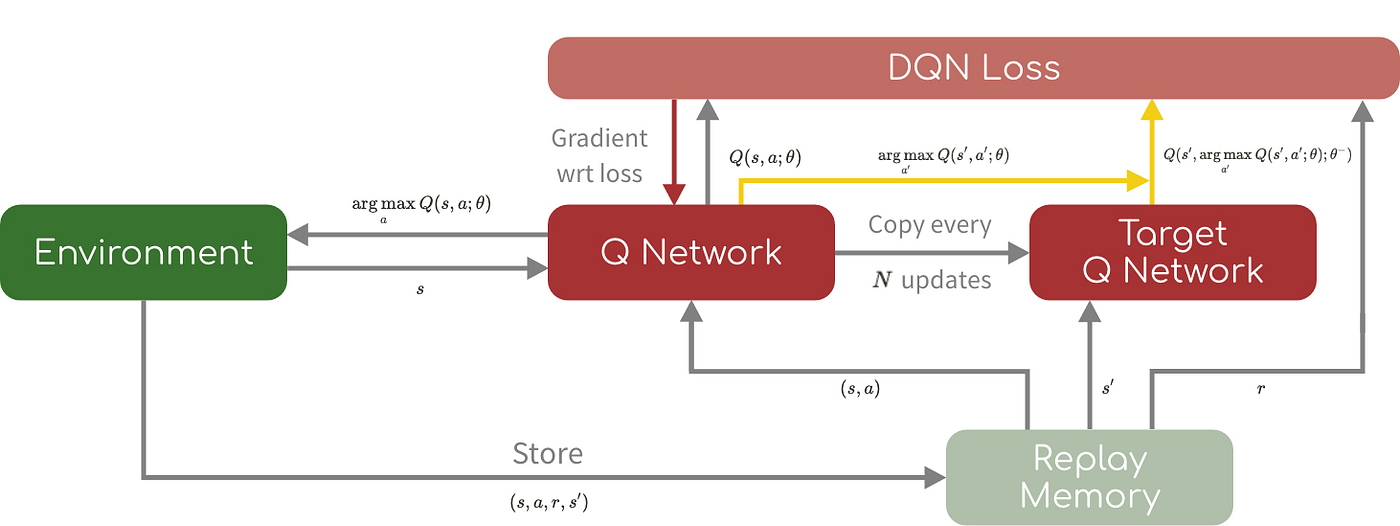

In [74]:
!pip install flappy-bird-gymnasium torch gymnasium

In [ ]:
import os
from datetime import datetime, timedelta
import argparse
RUNS_DIR = "runs"
os.makedirs(RUNS_DIR, exist_ok=True)

DATE_FORMAT = "%m-%d %H:%M:%S"

In [ ]:
config_content = '''
{

    "version": "0.2.0",
    "configurations": [
        {
            "name": "Train cartpole1",
            "type": "debugpy",
            "request": "launch",
            "program": "agent.py",
            "console": "integratedTerminal",
            "args": ["cartpole1", "--train"]
        },
        {
            "name": "Train flappybird1",
            "type": "debugpy",
            "request": "launch",
            "program": "agent.py",
            "console": "integratedTerminal",
            "args": ["flappybird1", "--train"]
        }
    ]
}
'''
with open('launch.json', 'w') as file:
    file.write(config_content)

In [ ]:
config_content = '''cartpole1:
  env_id: CartPole-v1
  replay_memory_size: 100000
  mini_batch_size: 32
  epsilon_init: 1
  epsilon_decay: 0.9995
  epsilon_min: 0.05
  network_sync_rate: 10
  learning_rate_a: 0.0001
  discount_factor_g: 0.99
  stop_on_reward: 100000
  fc1_nodes: 512
  env_make_params:
    use_lidar: False
  enable_double_dqn: True
  enable_dueling_dqn: False

flappybird1:
  env_id: FlappyBird-v0
  replay_memory_size: 100000
  mini_batch_size: 32
  epsilon_init: 1
  epsilon_decay: 0.99_99_5
  epsilon_min: 0.05
  network_sync_rate: 10
  learning_rate_a: 0.0001
  discount_factor_g: 0.99
  stop_on_reward: 100000
  fc1_nodes: 512
  env_make_params:
    use_lidar: False
  enable_double_dqn: True
  enable_dueling_dqn: False
'''

with open('hyperparameters.yml', 'w') as file:
    file.write(config_content)

In [118]:
import torch
from torch import nn
import torch.nn.functional as F


class DQN(nn.Module):

    def __init__(self, state_dim, action_dim, hidden_dim=256, enable_dueling_dqn=True):
        super(DQN, self).__init__()

        self.enable_dueling_dqn=enable_dueling_dqn

        self.fc1 = nn.Linear(state_dim, hidden_dim)

        if self.enable_dueling_dqn:
            # Value stream
            self.fc_value = nn.Linear(hidden_dim, 256)
            self.value = nn.Linear(256, 1)

            # Advantages stream
            self.fc_advantages = nn.Linear(hidden_dim, 256)
            self.advantages = nn.Linear(256, action_dim)

        else:
            self.output = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))

        if self.enable_dueling_dqn:
            # Value calc
            v = F.relu(self.fc_value(x))
            V = self.value(v)

            # Advantages calc
            a = F.relu(self.fc_advantages(x))
            A = self.advantages(a)

            # Calc Q
            Q = V + A - torch.mean(A, dim=1, keepdim=True)

        else:
            Q = self.output(x)

        return Q



state_dim = 12
action_dim = 2
net = DQN(state_dim, action_dim)
state = torch.randn(10, state_dim)
output = net(state)
print(output)


In [70]:
from collections import deque
import random

class ReplayMemory():
    def __init__(self, maxlen, seed=0):
        self.memory = deque([], maxlen=maxlen)

        if seed is not None:
            random.seed(seed)


    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

In [98]:
import gymnasium as gym
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import random
import torch
from torch import nn
import yaml



from datetime import datetime, timedelta
import argparse
import itertools

import flappy_bird_gymnasium
import os


DATE_FORMAT = "%m-%d %H:%M:%S"


RUNS_DIR = "runs"
os.makedirs(RUNS_DIR, exist_ok=True)

# 'Agg': used to generate plots as images and save them to a file instead of rendering to screen
matplotlib.use('Agg')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'


class Agent():

    def __init__(self, hyperparameter_set):
        with open('hyperparameters.yml', 'r') as file:
            all_hyperparameter_sets = yaml.safe_load(file)
            hyperparameters = all_hyperparameter_sets[hyperparameter_set]
            # print(hyperparameters)

        self.hyperparameter_set = hyperparameter_set


        self.env_id = hyperparameters['env_id']
        self.learning_rate_a    = hyperparameters['learning_rate_a']        # скорость обучения (альфа)
        self.discount_factor_g  = hyperparameters['discount_factor_g']      # коэффициент дисконтирования (гамма)
        self.network_sync_rate  = hyperparameters['network_sync_rate']      # количество шагов агента до синхронизации политической и целевой сетей
        self.replay_memory_size = hyperparameters['replay_memory_size']     # размер буфера воспроизведения опыта
        self.mini_batch_size    = hyperparameters['mini_batch_size']        # размер мини-партии данных для обучения, выбранной из буфера воспроизведения
        self.epsilon_init       = hyperparameters['epsilon_init']           # 1 = 100% случайных действий
        self.epsilon_decay      = hyperparameters['epsilon_decay']          # темп затухания эпсилон
        self.epsilon_min        = hyperparameters['epsilon_min']            # минимальное значение эпсилон
        self.stop_on_reward     = hyperparameters['stop_on_reward']         # остановить обучение при достижении этого количества наград
        self.fc1_nodes          = hyperparameters['fc1_nodes']
        self.env_make_params    = hyperparameters.get('env_make_params',{}) # Получить необязательные параметры среды, по умолчанию пустой словарь
        self.enable_double_dqn  = hyperparameters['enable_double_dqn']      # флаг включения/выключения двойного DQN
        self.enable_dueling_dqn = hyperparameters['enable_dueling_dqn']     # флаг включения/выключения дуэльного DQN


        self.loss_fn = nn.MSELoss()
        self.optimizer = None


        self.LOG_FILE   = os.path.join(RUNS_DIR, f'{self.hyperparameter_set}.log')
        self.MODEL_FILE = os.path.join(RUNS_DIR, f'{self.hyperparameter_set}.pt')
        self.GRAPH_FILE = os.path.join(RUNS_DIR, f'{self.hyperparameter_set}.png')

    def run(self, is_training=True, render=False):
        if is_training:
            start_time = datetime.now()
            last_graph_update_time = start_time

            log_message = f"{start_time.strftime(DATE_FORMAT)}: Training starting..."
            print(log_message)
            with open(self.LOG_FILE, 'w') as file:
                file.write(log_message + '\n')

        # Create instance of the environment.
        # Use "**self.env_make_params" to pass in environment-specific parameters from hyperparameters.yml.


        env = gym.make(self.env_id, render_mode='rgb_array' if render else None, **self.env_make_params)
        if render:
            env = RecordVideo(env, video_folder='video_flappy_bird', episode_trigger=lambda x: x % 1 == 0)

        num_actions = env.action_space.n
        num_states = env.observation_space.shape[0] # Expecting type: Box(low, high, (shape0,), float64)


        rewards_per_episode = []


        policy_dqn = DQN(num_states, num_actions, self.fc1_nodes, self.enable_dueling_dqn).to(device)

        if is_training:

            epsilon = self.epsilon_init


            memory = ReplayMemory(self.replay_memory_size)


            target_dqn = DQN(num_states, num_actions, self.fc1_nodes, self.enable_dueling_dqn).to(device)
            target_dqn.load_state_dict(policy_dqn.state_dict())


            self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)
            epsilon_history = []
            step_count=0
            best_reward = -9999999
        else:
            # тут загрузка
            policy_dqn.load_state_dict(torch.load(self.MODEL_FILE))
            policy_dqn.eval()


        for episode in itertools.count():

            state, _ = env.reset()
            state = torch.tensor(state, dtype=torch.float, device=device)

            terminated = False
            episode_reward = 0.0

            while(not terminated and episode_reward < self.stop_on_reward):

                if is_training and random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample()
                    action = torch.tensor(action, dtype=torch.int64, device=device)
                else:
                    # select best action
                    with torch.no_grad():

                        action = policy_dqn(state.unsqueeze(dim=0)).squeeze().argmax()


                new_state,reward,terminated,truncated,info = env.step(action.item())

                episode_reward += reward


                new_state = torch.tensor(new_state, dtype=torch.float, device=device)
                reward = torch.tensor(reward, dtype=torch.float, device=device)

                if is_training:

                    memory.append((state, action, new_state, reward, terminated))


                    step_count+=1


                state = new_state

            # Keep track of the rewards collected per episode.
            rewards_per_episode.append(episode_reward)
            if render:
                env.close()
                break

            if is_training:
                if episode_reward > best_reward:
                    log_message = f"{datetime.now().strftime(DATE_FORMAT)}: New best reward {episode_reward:0.1f} ({(episode_reward-best_reward)/best_reward*100:+.1f}%) at episode {episode}, saving model..."
                    print(log_message)
                    with open(self.LOG_FILE, 'a') as file:
                        file.write(log_message + '\n')

                    torch.save(policy_dqn.state_dict(), self.MODEL_FILE)
                    best_reward = episode_reward


                # Update graph every x seconds
                current_time = datetime.now()
                if current_time - last_graph_update_time > timedelta(seconds=10):
                    self.save_graph(rewards_per_episode, epsilon_history)
                    last_graph_update_time = current_time

                # If enough experience has been collected
                if len(memory)>self.mini_batch_size:
                    mini_batch = memory.sample(self.mini_batch_size)
                    self.optimize(mini_batch, policy_dqn, target_dqn)

                    # Decay epsilon
                    epsilon = max(epsilon * self.epsilon_decay, self.epsilon_min)
                    epsilon_history.append(epsilon)

                    # Copy policy network to target network after a certain number of steps
                    if step_count > self.network_sync_rate:
                        target_dqn.load_state_dict(policy_dqn.state_dict())
                        step_count=0


    def save_graph(self, rewards_per_episode, epsilon_history):
        # Save plots
        fig = plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        mean_rewards = np.zeros(len(rewards_per_episode))
        for x in range(len(mean_rewards)):
            mean_rewards[x] = np.mean(rewards_per_episode[max(0, x-99):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        # plt.xlabel('Episodes')
        plt.ylabel('Mean Rewards')
        plt.plot(mean_rewards)

        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        # plt.xlabel('Time Steps')
        plt.ylabel('Epsilon Decay')
        plt.plot(epsilon_history)

        plt.subplots_adjust(wspace=1.0, hspace=1.0)

        # Save plots
        fig.savefig(self.GRAPH_FILE)
        plt.close(fig)



    def optimize(self, mini_batch, policy_dqn, target_dqn):

        # Transpose the list of experiences and separate each element
        states, actions, new_states, rewards, terminations = zip(*mini_batch)

        # Stack tensors to create batch tensors
        # tensor([[1,2,3]])
        states = torch.stack(states)

        actions = torch.stack(actions)

        new_states = torch.stack(new_states)

        rewards = torch.stack(rewards)
        terminations = torch.tensor(terminations).float().to(device)

        with torch.no_grad():
            if self.enable_double_dqn:
                best_actions_from_policy = policy_dqn(new_states).argmax(dim=1)

                target_q = rewards + (1-terminations) * self.discount_factor_g * \
                                target_dqn(new_states).gather(dim=1, index=best_actions_from_policy.unsqueeze(dim=1)).squeeze()
            else:
                # Calculate target Q values (expected returns)
                target_q = rewards + (1-terminations) * self.discount_factor_g * target_dqn(new_states).max(dim=1)[0]
                '''
                    target_dqn(new_states)  ==> tensor([[1,2,3],[4,5,6]])
                        .max(dim=1)         ==> torch.return_types.max(values=tensor([3,6]), indices=tensor([3, 0, 0, 1]))
                            [0]             ==> tensor([3,6])
                '''

        # Calcuate Q values from current policy
        current_q = policy_dqn(states).gather(dim=1, index=actions.unsqueeze(dim=1)).squeeze()
        '''
            policy_dqn(states)  ==> tensor([[1,2,3],[4,5,6]])
                actions.unsqueeze(dim=1)
                .gather(1, actions.unsqueeze(dim=1))  ==>
                    .squeeze()                    ==>
        '''


        loss = self.loss_fn(current_q, target_q)

        # Optimize the model (backpropagation)
        self.optimizer.zero_grad()  # Clear gradients
        loss.backward()             # Compute gradients
        self.optimizer.step()       # Update network parameters i.e. weights and biases

# if __name__ == '__main__':
#     # Parse command line inputs
#     parser = argparse.ArgumentParser(description='Train or test model.')
#     parser.add_argument('hyperparameters', help='')
#     parser.add_argument('--train', help='Training mode', action='store_true')
#     args = parser.parse_args()

#     dql = Agent(hyperparameter_set=args.hyperparameters)

#     if args.train:
#         dql.run(is_training=True)
#     else:
#         dql.run(is_training=False, render=True)



In [96]:
dql = Agent(hyperparameter_set='flappybird1')

dql.run(is_training=True)


05-23 14:07:14: Training starting...
05-23 14:07:14: New best reward -6.9 (-100.0%) at episode 0, saving model...
05-23 14:07:14: New best reward -6.3 (-8.7%) at episode 9, saving model...
05-23 14:07:14: New best reward -1.5 (-76.2%) at episode 22, saving model...


Exception ignored in: <function RecordVideo.__del__ at 0x7964409ec360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py", line 415, in __del__
    if len(self.recorded_frames) > 0:
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'RecordVideo' object has no attribute 'recorded_frames'


05-23 14:07:16: New best reward 0.9 (-160.0%) at episode 172, saving model...


KeyboardInterrupt: 

In [105]:
!wget https://github.com/BardRimon/Study/raw/main/Reinforcement_Learning/HW2/runs/flappybird1.png -O runs/flappybird1.png
!wget https://github.com/BardRimon/Study/raw/main/Reinforcement_Learning/HW2/runs/flappybird1.pt -O runs/flappybird1.pt
!wget https://github.com/BardRimon/Study/raw/main/Reinforcement_Learning/HW2/runs/flappybird1.log -O runs/flappybird1.log

--2025-05-23 14:16:40--  https://github.com/BardRimon/Study/raw/main/Reinforcement_Learning/HW2/runs/flappybird1.png
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BardRimon/Study/main/Reinforcement_Learning/HW2/runs/flappybird1.png [following]
--2025-05-23 14:16:40--  https://raw.githubusercontent.com/BardRimon/Study/main/Reinforcement_Learning/HW2/runs/flappybird1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20608 (20K) [image/png]
Saving to: ‘runs/flappybird1.png’

runs/flappybird1.pn 100%[===================>]  20.12K  --.-KB/s    in 0s      

2025-05-23 14:16:41 (95.8 MB/s) - ‘runs/

### Смотрим на картинки

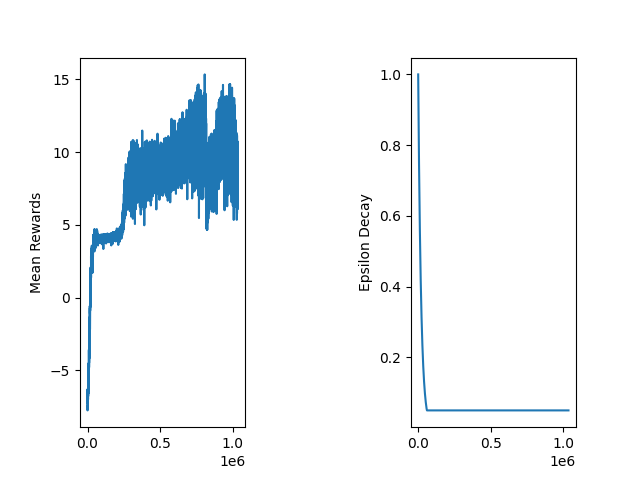

In [108]:
from IPython.display import display, Image, Video
image_path = '/content/runs/flappybird1.png'
display(Image(filename=image_path))

## Теперь посмотрим видео

In [100]:
from gymnasium.wrappers import RecordVideo
import gymnasium as gym

dql = Agent(hyperparameter_set='flappybird1')
dql.run(is_training=False, render=True)


In [110]:
!wget https://github.com/BardRimon/Study/raw/main/Reinforcement_Learning/HW2/good_video.mp4 -O video_flappy_bird/good_video.mp4
!wget https://github.com/BardRimon/Study/raw/main/Reinforcement_Learning/HW2/bad_video.mp4 -O video_flappy_bird/bad_video.mp4

--2025-05-23 14:19:28--  https://github.com/BardRimon/Study/raw/main/Reinforcement_Learning/HW2/good_video.mp4
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BardRimon/Study/main/Reinforcement_Learning/HW2/good_video.mp4 [following]
--2025-05-23 14:19:28--  https://raw.githubusercontent.com/BardRimon/Study/main/Reinforcement_Learning/HW2/good_video.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170426 (166K) [application/octet-stream]
Saving to: ‘video_flappy_bird/good_video.mp4’

video_flappy_bird/g 100%[===================>] 166.43K  --.-KB/s    in 0.01s   

2025-05-23 14:19:29 (11.8 MB/

In [116]:
video_path = '/content/video_flappy_bird/bad_video.mp4'
video = Video(video_path, width=288, height=512, embed=True)
display(video)


In [117]:
video_path = '/content/video_flappy_bird/good_video.mp4'
video = Video(video_path, width=288, height=512, embed=True)
display(video)